In [197]:
import numpy as np
import pandas as pd
import xarray as xr
import xgboost as xgb
import seaborn as sns
import itertools as it
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
%run ../src/models/geo_helpers.py
%run ../src/models/section_series.py
%matplotlib inline
pd.options.display.float_format = '{:,.4f}'.format

In [4]:
city_locations_path = '../data/external/' +\
    'worldcitiespop.txt'

city_locations = pd.read_csv(city_locations_path, encoding = "ISO-8859-1").rename(columns={'City': 'city'})
city_locations = city_locations[city_locations['Population'] > 0] # filter for populated cities
print('Shape: {}'.format(city_locations.shape))
city_locations.head()

Shape: (47980, 7)


,Country,city,AccentCity,Region,Population,Latitude,Longitude
6,ad,andorra la vella,Andorra la Vella,7.00,"20,430.00",42.50,1.52
20,ad,canillo,Canillo,2.00,"3,292.00",42.57,1.60
32,ad,encamp,Encamp,3.00,"11,224.00",42.53,1.58
49,ad,la massana,La Massana,4.00,"7,211.00",42.55,1.52
53,ad,les escaldes,Les Escaldes,8.00,"15,854.00",42.50,1.53


In [6]:
earthquake_locations_path = '../data/external/' +\
    'earthquakes_affected_locations/earthquakes_affected_locations.csv'

earthquake_locations = pd.read_csv(earthquake_locations_path, encoding = "ISO-8859-1").drop('country', axis=1)
earthquake_locations['city'] = earthquake_locations['city'].apply(lambda c: c.lower())
print('Shape: {}'.format(earthquake_locations.shape))
earthquake_locations.head()

Shape: (2719, 12)


,id,city,latitude,longitude,geoname,year,month,day,Totaldeaths,Totalaffected,Totaldamage000US,insured_losses
0,1,takhar,36.70,69.80,NaN,1992,5,20,14,0,0,0
1,2,jowzan,36.75,66.00,Jowzjan,1994,5,1,160,100330,0,0
2,2,mazar-i-sharif,36.75,67.00,mazar-i-sharif,1994,5,1,160,100330,0,0
3,2,balkh,36.75,66.90,balkh,1994,5,1,160,100330,0,0
4,2,termez,37.22,67.28,NaN,1994,5,1,160,100330,0,0


In [11]:
%run ../src/models/section_series.py
annual_frames = {}
for year in range(1993, 2014):
    print('Loading data for year {}'.format(year))
    try:
        annual_frames[year] = pd.read_csv('../data/processed/section_series_returns_small/{}.csv'.format(year)).set_index('city')
    except FileNotFoundError:
        earthquake_locations_in_year = earthquake_locations[earthquake_locations.year == year]
        earthquake_cities_in_year = earthquake_locations_in_year['city'].unique()
        annual_frames[year] = pd.merge(city_locations, earthquake_locations_in_year, on='city', how='left')
        annual_frames[year] = annual_frames[year].fillna(0).reset_index().groupby('city').agg({
            'Totaldeaths': 'sum',
            'Totalaffected': 'sum',
            'Totaldamage000US': 'sum',
            'insured_losses': 'sum',
            'Latitude': 'first',
            'Longitude': 'first',
            'city': 'first'
        }).set_index('city').rename(columns={
            'Latitude': 'latitude',
            'Longitude': 'longitude',
            'Totaldeaths': 'total_deaths',
            'Totalaffected': 'total_affected',
            'Totaldamage000US': 'total_damage_usd'
        })
        annual_frames[year]['year'] = year
        annual_frames[year]['earthquake_dummy'] = annual_frames[year].index.map(lambda c: c in earthquake_cities_in_year)
        series_loader = SectionSeriesLoader(
            img_shape=(200, 200),
            start_year=year,
            end_year=year,
            SRC_PATH='../data/interim/Version_4_DMSP-OLS_Nighttime_Lights_Time_Returns/*.npz')
        target_coords_list = [{'lat': r[0],'lng': r[1]} for r
            in annual_frames[year][['latitude', 'longitude']].values]
        annual_frames[year]['mean_luminosity_return'] = series_loader.load_multiple_means(target_coords_list).reshape(-1)
        annual_frames[year].to_csv('../data/processed/section_series_returns_small/{}.csv'.format(year))
        
    print(annual_frames[year].shape)
    
panel = xr.Dataset.from_dataframe(pd.concat(annual_frames))
del annual_frames

Loading data for year 1993
Loading file ../data/interim/Version_4_DMSP-OLS_Nighttime_Lights_Time_Returns/F101993.v4b_web.stable_lights.avg_vis.tif.npz


/usr/local/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/local/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(43183, 9)
Loading data for year 1994
Loading file ../data/interim/Version_4_DMSP-OLS_Nighttime_Lights_Time_Returns/F121994.v4b_web.stable_lights.avg_vis.tif.npz
(43183, 9)
Loading data for year 1995
Loading file ../data/interim/Version_4_DMSP-OLS_Nighttime_Lights_Time_Returns/F121995.v4b_web.stable_lights.avg_vis.tif.npz
(43183, 9)
Loading data for year 1996
Loading file ../data/interim/Version_4_DMSP-OLS_Nighttime_Lights_Time_Returns/F121996.v4b_web.stable_lights.avg_vis.tif.npz
(43183, 9)
Loading data for year 1997
Loading file ../data/interim/Version_4_DMSP-OLS_Nighttime_Lights_Time_Returns/F141997.v4b_web.stable_lights.avg_vis.tif.npz
(43183, 9)
Loading data for year 1998
Loading file ../data/interim/Version_4_DMSP-OLS_Nighttime_Lights_Time_Returns/F141998.v4b_web.stable_lights.avg_vis.tif.npz
(43183, 9)
Loading data for year 1999
Loading file ../data/interim/Version_4_DMSP-OLS_Nighttime_Lights_Time_Returns/F141999.v4b_web.stable_lights.avg_vis.tif.npz
(43183, 9)
Loading data for 

In [26]:
panel

<xarray.Dataset>
Dimensions:                 (city: 2351892, level_0: 21)
Coordinates:
  * level_0                 (level_0) int64 1993 1994 1995 1996 1997 1998 ...
  * city                    (city) object '0' ' bab el ahmar' ...
Data variables:
    latitude                (level_0, city) float64 42.01 33.53 -22.82 42.43 ...
    total_affected          (level_0, city) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...
    total_damage_usd        (level_0, city) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...
    insured_losses          (level_0, city) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...
    total_deaths            (level_0, city) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...
    longitude               (level_0, city) float64 20.42 35.83 31.96 18.49 ...
    year                    (level_0, city) int64 1993 1993 1993 1993 1993 ...
    earthquake_dummy        (level_0, city) bool False False False False ...
    mean_luminosity_return  (level_0, city) float64 -0.5681 0.28 -2.5e-05 ...

In [61]:
%%time
try:
    data = pd.read_csv('../data/processed/section_series_returns_small/all.csv').set_index('city')
except FileNotFoundError:
    feature_cols = ['latitude', 'longitude', 'mean_luminosity_return', 'total_affected', 'total_damage_usd', 'insured_losses',
                    'total_deaths', 'earthquake_dummy']
    data = pd.melt(
        panel.to_dataframe()[feature_cols].reset_index(),
        id_vars=['city','level_0'],
        value_vars=feature_cols)\
        .rename(columns={'level_0': 'year'})
    data = data\
        .set_index(data[['year','variable']].astype(str).apply(lambda r: '_'.join(r), axis=1))\
        .drop(['year','variable'], axis=1)
    data = data.groupby(['city']).apply(lambda g: g.transpose().loc['value',:])
    data.to_csv('../data/processed/section_series_returns_small/all.csv')

data.head()

CPU times: user 2.11 s, sys: 162 ms, total: 2.27 s
Wall time: 2.36 s


In [194]:
targets = data[['2013_mean_luminosity_return']].fillna(0)
features = data.drop(['2013_mean_luminosity_return'], axis=1)

In [202]:
def cross_validate(features, targets, params, n_splits=3):
    k_fold = KFold(n_splits=n_splits, shuffle=True, random_state=23)
    param_names = list(params.keys())
    result = pd.DataFrame(columns=['mse','wmse','mae','wmae','r2','wr2','ev','wev'] + param_names)
    for train, test in k_fold.split(features, targets):
        train_data = xgb.DMatrix(data=features.iloc[train].values,
                                 label=targets.iloc[train].values,
                                 feature_names=features.columns)
        test_data = xgb.DMatrix(data=features.iloc[test].values,
                                label=targets.iloc[test].values,
                                feature_names=features.columns)
        linear_tree_booster = xgb.train(
            params={
                'booster': 'gbtree',
                'objective': 'reg:linear',
                **params
            },
            dtrain=train_data,
            num_boost_round=25
        )
        pred = np.nan_to_num(linear_tree_booster.predict(test_data))
        result = result.append(pd.DataFrame({
            'mse': mean_squared_error(test_data.get_label(), pred),
            'wmse': mean_squared_error(test_data.get_label(), pred, sample_weight=test_data.get_label()),
            'mae': mean_absolute_error(test_data.get_label(), pred),
            'wmae': mean_absolute_error(test_data.get_label(), pred, sample_weight=test_data.get_label()),
            'r2': r2_score(test_data.get_label(), pred),
            'wr2': r2_score(test_data.get_label(), pred, sample_weight=test_data.get_label()),
            'ev': explained_variance_score(test_data.get_label(), pred),
            'wev': explained_variance_score(test_data.get_label(), pred, sample_weight=test_data.get_label()),
            **params
        }, index=[str(params)])) 
        
    return result.mean()


param_grid = {
    'n_estimators': [50,100,150],
    'eta': [.05,.1,.3],
    'max_depth': [2,6,10],
    'alpha': [.1, .2]
}
param_list = [dict(zip(param_grid, v)) for v in it.product(*param_grid.values())]
cv_results = pd.DataFrame(columns=['mse','wmae','mae','wmse','r2','wr2','ev','wev'] + list(param_grid.keys()))
for params in param_list:
    cv_results = cv_results.append(cross_validate(features, targets, params), ignore_index=True)
    
cv_results.groupby(list(param_grid.keys())).mean().head()

,mse,wmae,mae,wmse,r2,wr2,ev,wev
n_estimators,,,,,,,,
10.0000,0.0396,0.1411,0.1314,0.0401,0.9587,1.0588,0.9587,1.0408


In [322]:
pred = linear_tree_booster.predict(test_data)
test_ae = test_data.get_label() - pred
test_wae = (test_data.get_label() - pred) * test_data.get_label()
test_mse = mean_squared_error(test_data.get_label(), pred)
true_mean = test_data.get_label().mean()

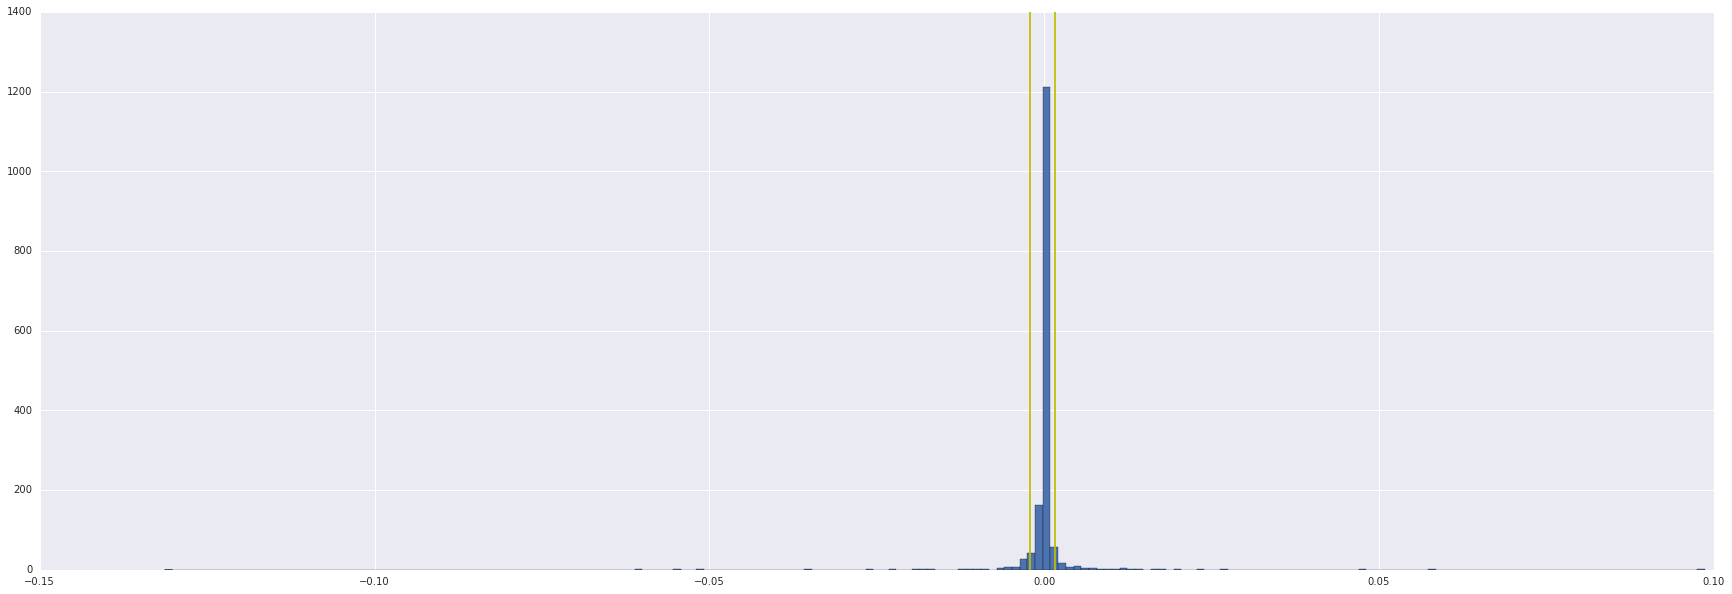

In [282]:
plt.figure(figsize=(30,10))
plt.hist(test_wae, bins=200)
plt.axvline(x=np.percentile(test_wae, 95), c='y')
plt.axvline(x=np.percentile(test_wae, 5), c='y')
plt.show()

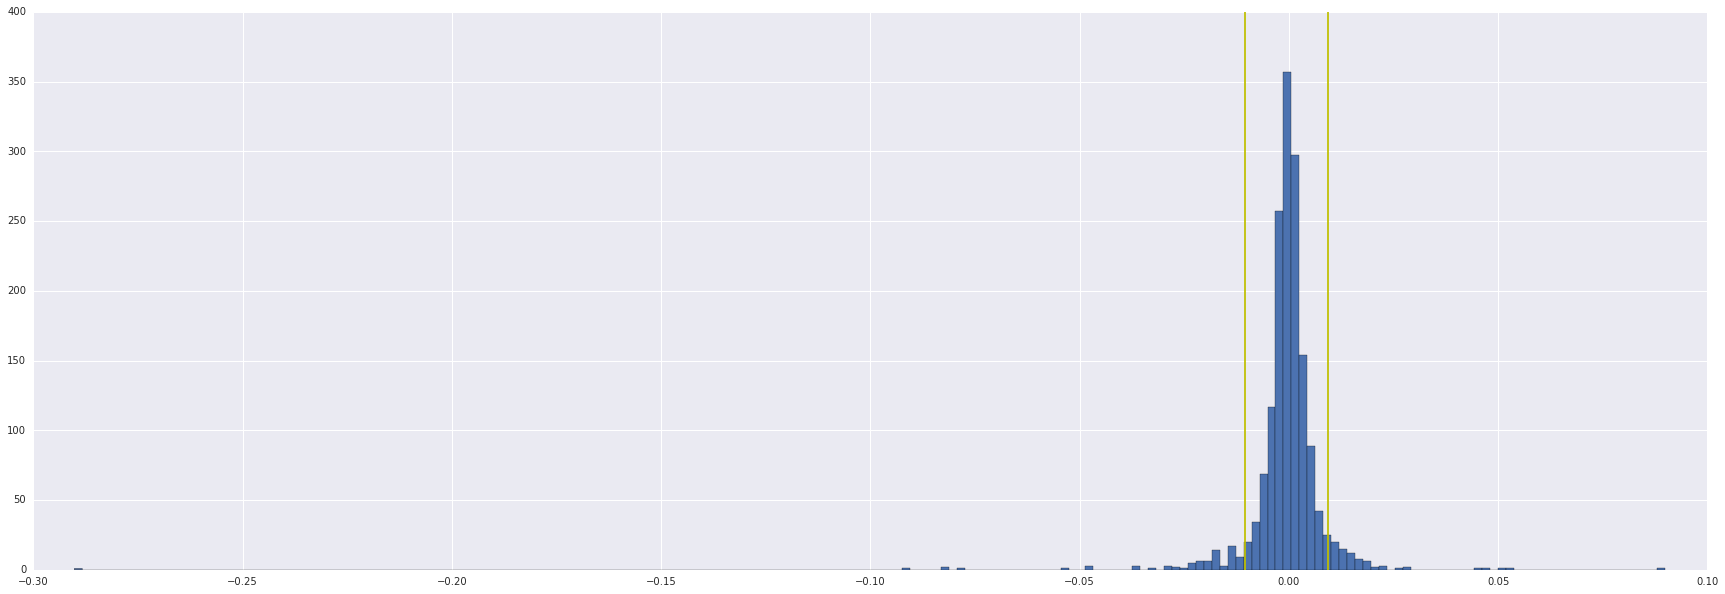

In [283]:
plt.figure(figsize=(30,10))
plt.hist(test_ae, bins=200)
plt.axvline(x=np.percentile(test_ae, 95), c='y')
plt.axvline(x=np.percentile(test_ae, 5), c='y')
plt.show()

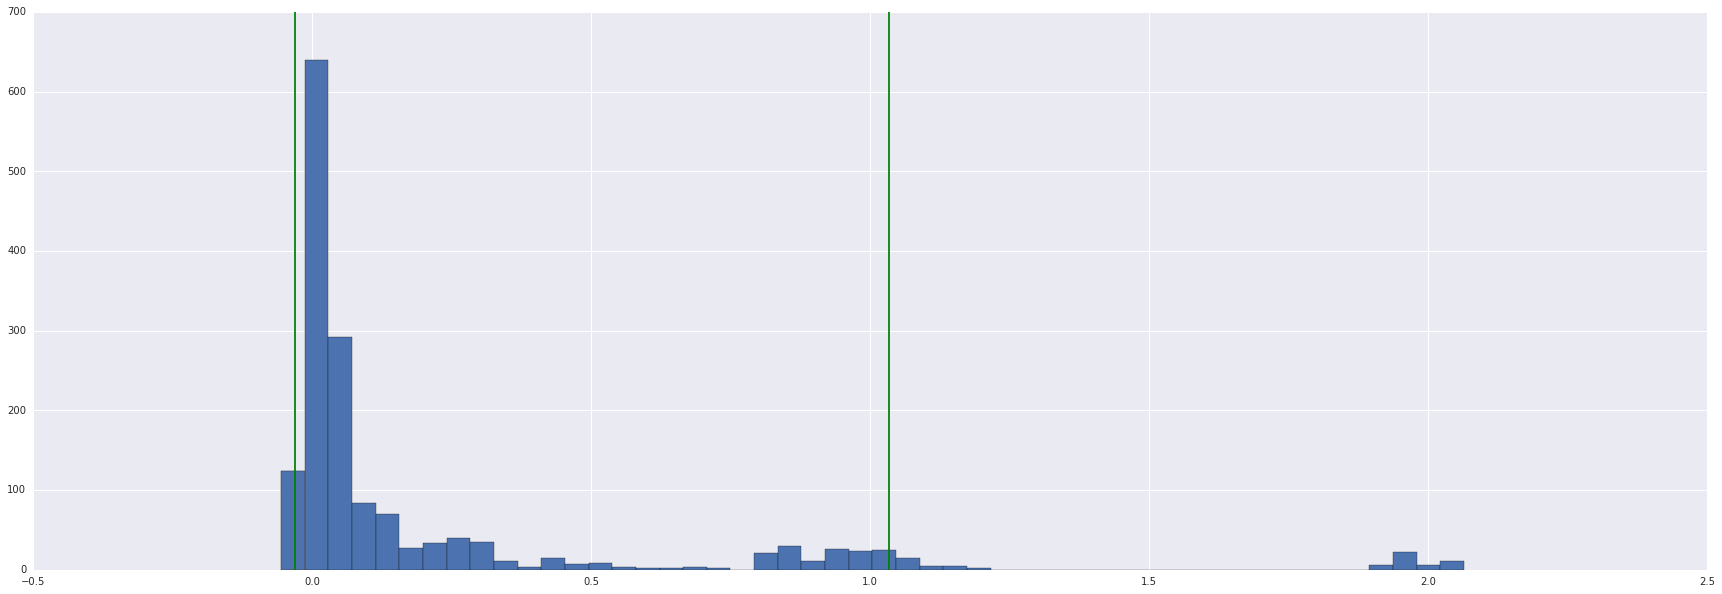

In [284]:
plt.figure(figsize=(30,10))
plt.hist(test_data.get_label(), bins=50)
plt.axvline(x=np.percentile(test_data.get_label(), 95), c='g')
plt.axvline(x=np.percentile(test_data.get_label(), 5), c='g')
plt.show()

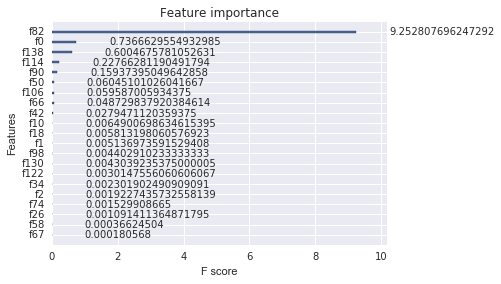

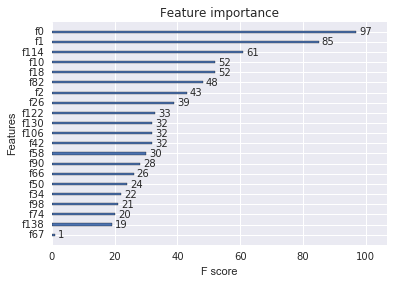

In [331]:
xgb.plot_importance(linear_tree_booster, importance_type='gain')
xgb.plot_importance(linear_tree_booster, importance_type='weight')

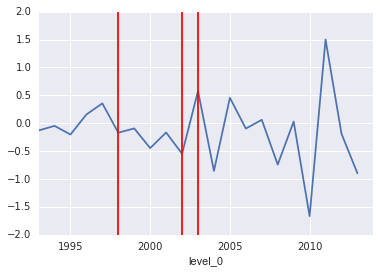

In [316]:
df = panel.sel(city='takhar').to_dataframe()
df['mean_luminosity_return'].plot()
for i, row in df[df['earthquake_dummy'] == True].iterrows():
    plt.axvline(x=row.year, c='r')

In [406]:
city_df = panel.sel(city='takhar')\
    .to_dataframe()[['latitude',
                     'longitude',
                     'mean_luminosity_return',
                     'total_affected',
                     'total_damage_usd',
                     'insured_losses',
                     'total_deaths',
                     'earthquake_dummy']].reset_index()
feature = city_df[(city_df.level_0 <= 2012) & (city_df.level_0 > 1994)].drop('level_0', axis=1).values.reshape(-1)
target = city_df[city_df.level_0 == 2013]['mean_luminosity_return'].mean()
# print('True: {}, Predicted: {}'.format(target,linear_tree_booster.predict(xgb.DMatrix(feature.reshape(1,-1)))))

In [409]:
city_df

,level_0,latitude,longitude,mean_luminosity_return,total_affected,total_damage_usd,insured_losses,total_deaths,earthquake_dummy
0,1993,47.56,124.22,-0.13,0.00,0.00,0.00,0.00,False
1,1994,47.56,124.22,-0.05,0.00,0.00,0.00,0.00,False
2,1995,47.56,124.22,-0.20,0.00,0.00,0.00,0.00,False
3,1996,47.56,124.22,0.16,0.00,0.00,0.00,0.00,False
4,1997,47.56,124.22,0.36,0.00,0.00,0.00,0.00,False
5,1998,47.56,124.22,-0.17,"32,818.00","10,000.00",0.00,"2,323.00",True
6,1999,47.56,124.22,-0.09,0.00,0.00,0.00,0.00,False
7,2000,47.56,124.22,-0.45,0.00,0.00,0.00,0.00,False
8,2001,47.56,124.22,-0.17,0.00,0.00,0.00,0.00,False
9,2002,47.56,124.22,-0.55,"3,513.00",0.00,0.00,150.00,True
